In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [119]:
### Auxiliary functions ###


# generate random data (gray scale images with higher intensity in the right side of the image)
def generate_data(N, M):
    X = torch.zeros((M,N*N))
    for i in range(M):
        x = (torch.randint(0,256,(N,N))*torch.ones((N,N))*(torch.logspace(0,-3,N)))/255
        X[i,:] = x.reshape(1,N*N)
    return X


def sigmoid(x):
    return np.divide(1, 1 + np.exp(-x))


# loss function with l1 regularization (for comparison)
def loss_fun(E, D, X, lam):
    val = 0
    M = X.shape[1]
    for m in range(M):
        Xm = X[:,m]
        h = sigmoid(E@Xm)
        val += val + np.linalg.norm(sigmoid(D@h) - Xm)**2 + lam*np.linalg.norm(h, 1)
    return (1/M)*val

In [147]:
# ANAMO (Autoencoder NAM Optimizer)


# calaculate gradient of decoder (one layer network with sigmoid)
def grad_decoder(D, E, X):
    (n, N, M) = (E.shape[0], int(np.sqrt(E.shape[1])), X.shape[1])
    grad_D = np.zeros((N*N,n))
    for m in range(M):
        h = sigmoid(E@X[:,m])
        sig_Dh = [sigmoid(D[k,:]@h) for k in range(N*N)]

        grad_D_x = [(sig_Dh[k]-X[k,m])*(sig_Dh[k]**2-sig_Dh[k])*h[i] for k in range(N*N) for i in range(n)]
        grad_D += grad_D - 2*np.asarray(grad_D_x).reshape(N*N,n)
        return (1/M)*2*grad_D
    

# calaculate gradient of encoder (one layer network with sigmoid)
def grad_encoder(D, E, X, lam):
    (n, N, M) = (E.shape[0], int(np.sqrt(E.shape[1])), X.shape[1])
    grad_E = np.zeros((n,N*N))
    
    for m in range(M):
        h = sigmoid(E@X[:,m])
        sig_Dh = [sigmoid(D[k,:]@h) for k in range(N*N)]

        grad_E1_x = np.zeros((n,N*N))
        for i in range(n):
            for j in range(N*N):
                for k in range(N*N):
                    grad_E1_x[i,j] += (sig_Dh[k]-X[k,m])*(sig_Dh[k]**2-sig_Dh[k])*D[k,i]*(h[i]**2-h[i])*X[j,m]

        grad_E2_x = [(h[i]**2-h[i])*X[j,m] for i in range(n) for j in range(N*N)]

        grad_E += grad_E + np.asarray(grad_E1_x).reshape(n,N*N) + lam*np.asarray(grad_E2_x).reshape(n,N*N)
        return (1/M)*2*grad_E

    
def anamo_autoencoder(n, init_weight, iter_anamo, X, lr_anamo, lam):

    X = torch.Tensor.numpy(X).T  # numpy array representation of the data
    N = int(np.sqrt(X.shape[0]))  # size of square matrix
    lr_encoder, lr_decoder = (lr_anamo[0], lr_anamo[1])  # learning rates
    E, D = (torch.Tensor.numpy(init_weight[0]), torch.Tensor.numpy(init_weight[1]))  # initial weights
    out_iter, in_iter_E, in_iter_D = (iter_anamo[0], iter_anamo[1], iter_anamo[2])  # number of iterations
    it = 0  # total iteration counter

    # initial loss calculations
    val_loss_anamo = np.zeros((out_iter*(in_iter_E+in_iter_D)+1,1))   
    loss_val_init = loss_fun(E, D, X, lam)
    val_loss_anamo[it] = loss_val_init
    print("Starting ANAMO autoencoder. Initial loss value:", loss_val_init)
    
    # run ANAMO
    for q in range(out_iter):
        
        # Encoder update
        (y, s) = (E, 1)  # initialize FISTA
        for p in range(in_iter_E):
            (E_prev, s_prev) = (E, s)
            E = y - lr_encoder*grad_encoder(D, y, X, lam)
            s = (1+np.sqrt(1+4*s**2))/2
            y = E + ((s_prev - 1)/s)*(E - E_prev)
            
            # loss calculations
            it += 1
            loss_val_E = loss_fun(E, D, X, lam)
            val_loss_anamo[it] = loss_val_E

        # Decoder update
        (y, s) = (D, 1)   # initialize FISTA
        for p in range(in_iter_D):
            (D_prev, s_prev) = (D, s)
            D = y - lr_decoder*grad_decoder(y, E, X)
            s = (1+np.sqrt(1+4*s**2))/2
            y = D + ((s_prev - 1)/s)*(D - D_prev)

            # loss calculations
            it += 1
            loss_val_D = loss_fun(E, D, X, lam)
            val_loss_anamo[it] = loss_val_D
        
        print('Outer iteration: ' + str(q+1) + '/' + str(out_iter) + 
              ' | Encoder update loss: ' + str(loss_val_E) + ' | Decoder update loss: ' + str(loss_val_D))
    
    return val_loss_anamo, E, D

In [70]:
### ADAM (torch autoencoder implementation) ###


class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder_weights, decoder_weights):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False),
            nn.Sigmoid())
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size, bias=False),
            nn.Sigmoid())
        
        # Set initial weights
        self.encoder[0].weight.data = nn.Parameter(encoder_weights)
        self.decoder[0].weight.data = nn.Parameter(decoder_weights)


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

def adam_autoencoder(n, init_weight, num_epochs, X, lam):
    
    X_np = torch.Tensor.numpy(X).T  # numpy array representation of the data
    N = int(np.sqrt(X_np.shape[0]))  # size of square matrix
    E_init, D_init = (init_weight[0], init_weight[1])
    
    # initial loss calculations
    val_loss_adam = np.zeros((num_epochs+1,1))
    loss_val_init = loss_fun(torch.Tensor.numpy(E_init), torch.Tensor.numpy(D_init), X_np, lam)
    val_loss_adam[0] = loss_val_init
    
    # set model
    model = Autoencoder(N*N, n, E_init, D_init)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    print("Starting ADAM autoencoder. Initial loss value:", loss_val_init)
    
    # run ADAM
    for epoch in range(num_epochs):
        # Forward
        outputs = model(X)
        loss = criterion(outputs, X)

        # Backpropagtion and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss calculations
        E = torch.Tensor.numpy(model.encoder[0].weight.data)
        D = torch.Tensor.numpy(model.decoder[0].weight.data)
        loss_val = loss_fun(E, D, X_np, lam)
        val_loss_adam[epoch+1] = loss_val
        if (epoch % 10 == 0):
            print('ADAM | Epoch:' + str(epoch+1) + '/' + str(num_epochs) + ' | Loss:' +str(loss_val))
        
    return val_loss_adam, E, D

In [156]:
np.random.seed(1)
torch.manual_seed(1)


N, n, M = (10, 10, 100)  # (square matrix size, hidden layer, size of dataset)


# ANAMO hyperparameters
lam = 0.1  # encoder regularization constant
lr_anamo = (n, n)  # (encoder learning rate, decoder learning rate)
iter_anamo = (10, 5, 15)  # (ANAMO out iter, inner encoder iter, inner decoder iter)


X = generate_data(N, M)  # generate the dataset
init_weight = (torch.randn(n, N*N), torch.randn(N*N, n))  # the same initial weights for ANAMO and ADAM
num_epochs = iter_anamo[0]*(iter_anamo[1]+iter_anamo[2])  # this is much more iterations than ANAMO, but the comparisom is more convinient


loss_anamo, E_anamo, D_anamo = anamo_autoencoder(n, init_weight, iter_anamo, X, lr_anamo, lam)
loss_adam, E_adam, D_adam = adam_autoencoder(n, init_weight, num_epochs, X, lam)

#val_grad = np.zeros((out_iter*(in_iter_E+in_iter_D)+1,1))
#val_grad[it] = np.sqrt(np.linalg.norm(grad_encoder(D, E, X, lam),'fro')**2 + np.linalg.norm(grad_decoder(D, E, X),'fro')**2)

Starting ANAMO autoencoder. Initial loss value: 3.640038811150863e+29
Outer iteration: 1/10 | Encoder update loss: 3.038388564540294e+29 | Decoder update loss: 7.077261199451029e+28
Outer iteration: 2/10 | Encoder update loss: 6.306572819910757e+28 | Decoder update loss: 3.879654378583003e+28
Outer iteration: 3/10 | Encoder update loss: 3.715909147734183e+28 | Decoder update loss: 3.086116827249118e+28
Outer iteration: 4/10 | Encoder update loss: 3.0465166033293453e+28 | Decoder update loss: 2.911396764675472e+28
Outer iteration: 5/10 | Encoder update loss: 2.9046328494198904e+28 | Decoder update loss: 2.8267282668698485e+28
Outer iteration: 6/10 | Encoder update loss: 2.8323116696447703e+28 | Decoder update loss: 2.777657108496408e+28
Outer iteration: 7/10 | Encoder update loss: 2.7888555950480406e+28 | Decoder update loss: 2.746215347422353e+28
Outer iteration: 8/10 | Encoder update loss: 2.760154623048069e+28 | Decoder update loss: 2.7259344240551624e+28
Outer iteration: 9/10 | Enco

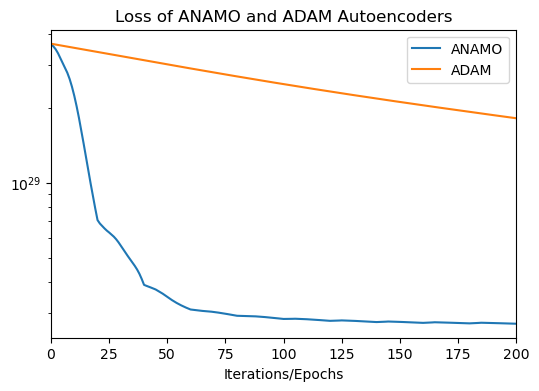

ANAMO average bias is 1.8488902382794619  |  ADAM average bias is 3.6969800233840946
Left: original test image. Middle: ANAMO reconstruction. Right: ADAM reconstruction.


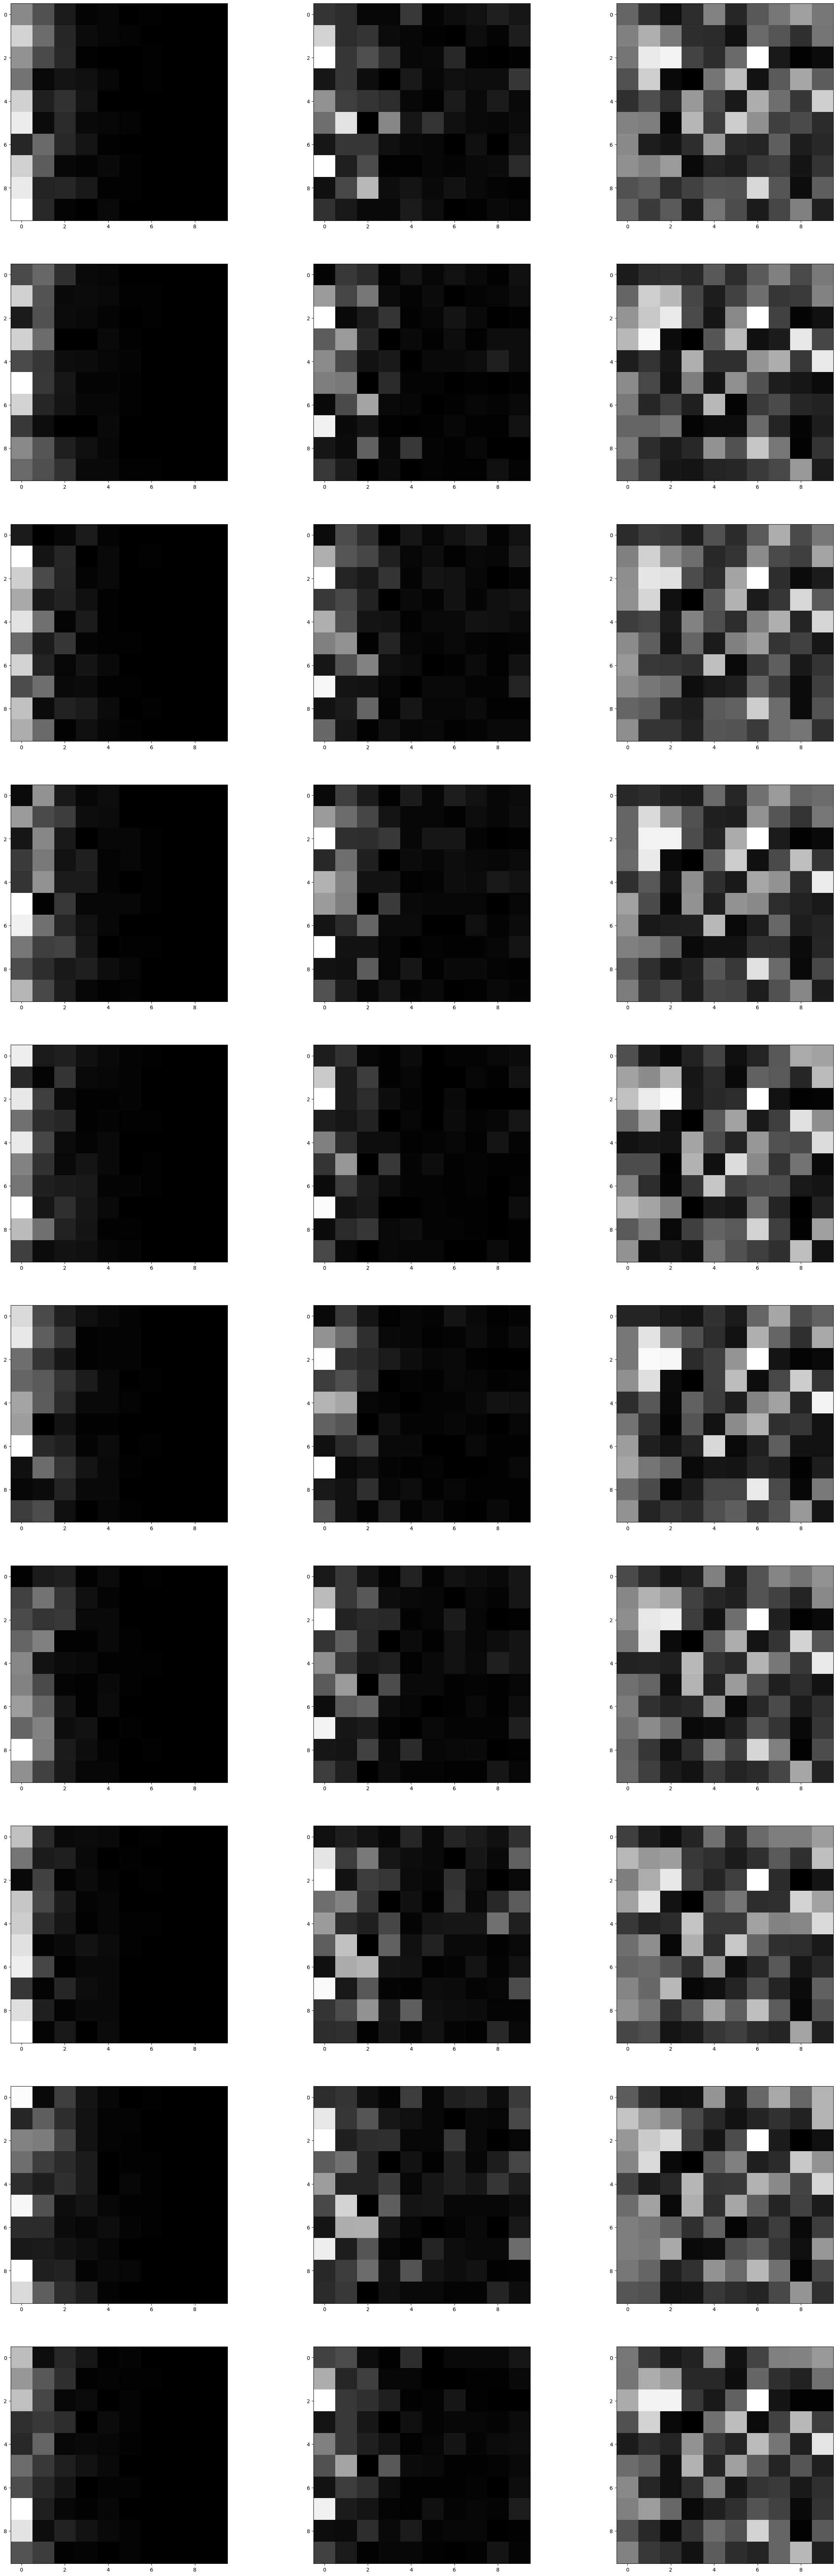

In [165]:
# plot loss values (with regularization for both)

plt.figure(figsize=(6,4))
plt.semilogy(loss_anamo)
plt.semilogy(loss_adam)
plt.legend(['ANAMO','ADAM'])
plt.title('Loss of ANAMO and ADAM Autoencoders')
plt.xlim([0, num_epochs])
plt.xlabel('Iterations/Epochs')
plt.savefig('loss.png')
plt.show()


# test the bias of the autoencoders
MM = 10  # size of test set
X_test = torch.Tensor.numpy(generate_data(N, MM)).T
bias_anamo, bias_adam = (0,0)
_, ax = plt.subplots(MM,3, figsize=(30,90))

for m in range(MM):
    x = X_test[:,m]
    pred_anamo = sigmoid(D_anamo@(sigmoid(E_anamo@x)))
    pred_adam = sigmoid(D_adam@(sigmoid(E_adam@x)))
    bias_anamo += (1/MM)*np.linalg.norm(x - pred_anamo)
    bias_adam += (1/MM)*np.linalg.norm(x - pred_adam)
    
    ax[m, 0].imshow(x.reshape(N,N), cmap='gray')
    ax[m, 1].imshow(pred_anamo.reshape(N,N), cmap='gray')
    ax[m, 2].imshow(pred_adam.reshape(N,N), cmap='gray')

plt.savefig('images.png')
print('ANAMO average bias is ' + str(bias_anamo) +'  |  ADAM average bias is ' + str(bias_adam))
print('Left: original test image. Middle: ANAMO reconstruction. Right: ADAM reconstruction.')